In [96]:
import wrf
import netCDF4 as nc
import numpy as np
import glob
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import xarray as xr
import pyart


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



<frozen importlib._bootstrap>:283: DeprecationWarning: the load_module() method is deprecated and slated for removal in Python 3.12; use exec_module() instead


0.3.0


In [7]:
#Load the WRF simulation output. Currently, the standard wrfout files are hourly, whereas the highres files are 10-minute, but only contain surface winds
wrflist = [nc.Dataset(f) for f in np.sort(glob.glob("/g/data/w40/ab4502/WRF_simulations/tasman_d04_20231015_20231016_ramssa/highres_d04*"))]


/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/xarray/plot/accessor.py:1190: DeprecationWarning: Using positional arguments is deprecated for plot methods, use keyword arguments instead.
  return dataset_plot.quiver(self._ds, *args, **kwargs)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/xarray/plot/accessor.py:1190: DeprecationWarning: Using positional arguments is deprecated for plot methods, use keyword arguments instead.
  return dataset_plot.quiver(self._ds, *args, **kwargs)


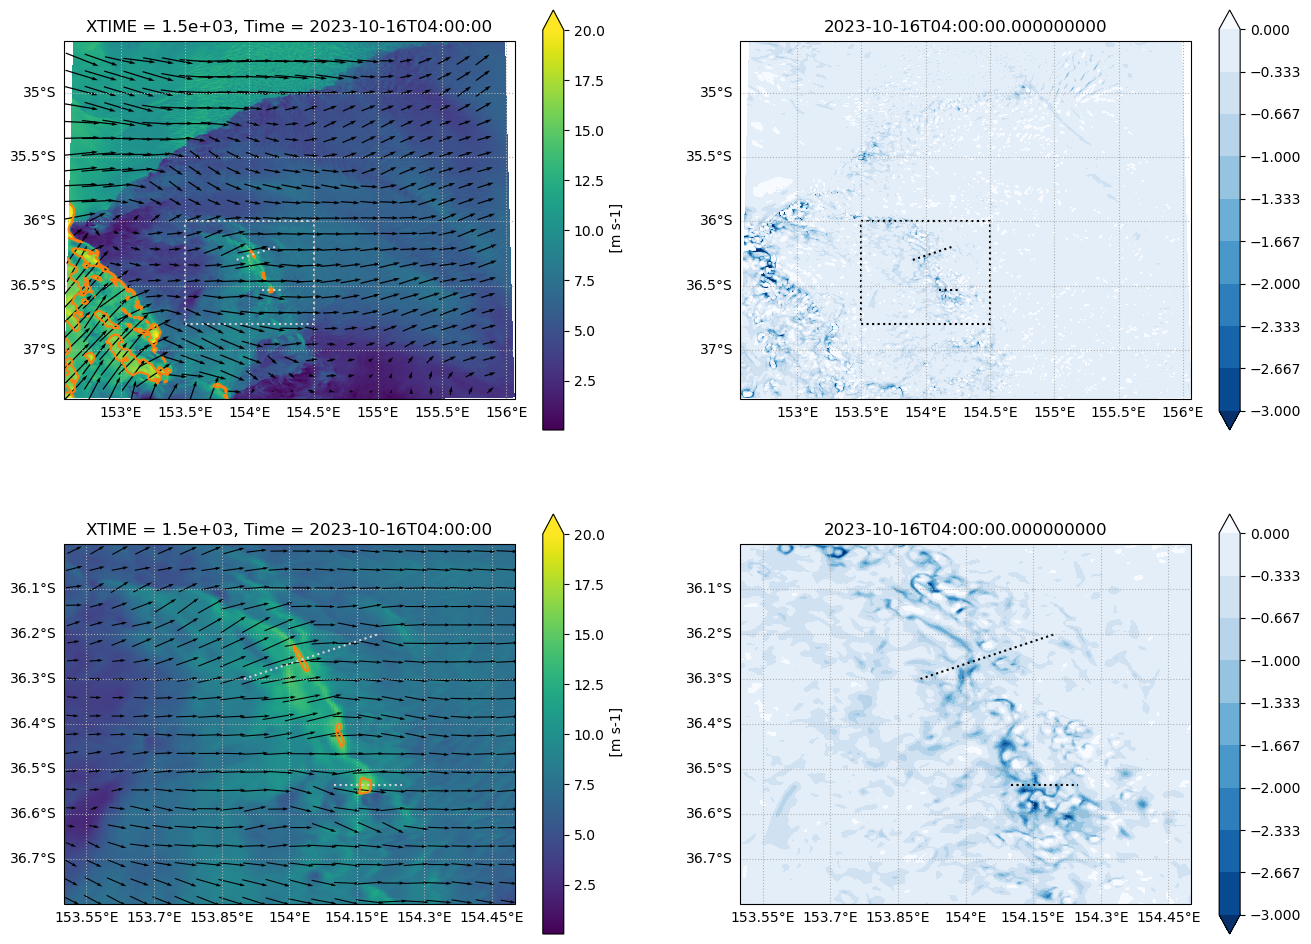

In [116]:
def plot(file_list,v,t_ind,ax,levels=None,cmap=None,lev=None,vmax=None):
    
    #Code to plot lat-lon contours of various quantities
    
    if v == "REFL_10CM":
        p1 = wrf.getvar(file_list, v, timeidx=t_ind, method="cat")
        time=p1.Time.values[t_ind]
        c=xr.plot.contourf(p1.isel({"Time":t_ind}).max("bottom_top"),x="XLONG",y="XLAT",transform=ccrs.PlateCarree(),ax=ax,levels=levels,cmap=cmap)
    elif v == "THETA":
        p1 = wrf.getvar(file_list, "theta", timeidx=t_ind, method="cat")
        time=p1.Time.values
        c=xr.plot.contourf(p1.isel({"bottom_top":0}),x="XLONG",y="XLAT",transform=ccrs.PlateCarree(),ax=ax,levels=levels,cmap=cmap)      
    elif v == "THETA-E":
        p1 = wrf.getvar(file_list, "theta_e", timeidx=t_ind, method="cat")
        time=p1.Time.values[t_ind]
        c=xr.plot.contourf(p1.isel({"bottom_top":0}),x="XLONG",y="XLAT",transform=ccrs.PlateCarree(),ax=ax,levels=levels,cmap=cmap)              
    elif v == "W_MIN":
        heights = wrf.getvar(file_list,"z",timeidx=t_ind)
        p1 = wrf.getvar(file_list, "wa", timeidx=t_ind)
        time=p1.Time.values
        p1 = xr.where(heights < 5000, p1, np.nan)
        c=xr.plot.contourf(p1.min("bottom_top"),x="XLONG",y="XLAT",transform=ccrs.PlateCarree(),ax=ax,levels=levels,cmap=cmap)        
    elif v == "W":
        heights = wrf.getvar(file_list,"z",timeidx=t_ind)
        p1 = wrf.getvar(file_list, "wa", timeidx=t_ind, method="cat")
        time=p1.Time.values
        p1 = wrf.interplevel(p1,heights,lev)
        c=xr.plot.contourf(p1,x="XLONG",y="XLAT",transform=ccrs.PlateCarree(),ax=ax,levels=levels,cmap=cmap)                
    elif v == "WS10":
        p1 = wrf.getvar(file_list, "U10", timeidx=t_ind)
        time=p1.Time.values
        p2 = wrf.getvar(file_list, "V10", timeidx=t_ind)
        p=np.sqrt(p1**2+p2**2)
        p.attrs=p1.attrs
        c=xr.plot.pcolormesh(p,x="XLONG",y="XLAT",transform=ccrs.PlateCarree(),ax=ax,levels=levels,cmap=cmap,vmax=vmax)
        c=xr.plot.contour(p,x="XLONG",y="XLAT",transform=ccrs.PlateCarree(),ax=ax,levels=[15],colors=["tab:orange"])    
    elif v == "W_DN_MAX":
        p1 = wrf.getvar(file_list, v, timeidx=t_ind)
        time=p1.Time.values
        c=xr.plot.contourf(p1,x="XLONG",y="XLAT",transform=ccrs.PlateCarree(),ax=ax,levels=levels,cmap=cmap)        
    else:
        p1 = wrf.getvar(file_list, v, timeidx=t_ind, method="cat")
        time=p1.Time.values[t_ind]
        c=xr.plot.contourf(p1.isel({"Time":t_ind}),x="XLONG",y="XLAT",transform=ccrs.PlateCarree(),ax=ax,levels=levels,cmap=cmap)
    plt.title(time)
    
#PLOT THETA WITH TRANSECT
t_ind = 24*6 + 6

lons1 = [153.9,154.2]
lats1 = [-36.3,-36.2]
lons2 = [154.1,154.25]
lats2 = [-36.535,-36.535]

xlim = [153.5,154.5]
ylim = [-36.8,-36]

coarsen=30

plt.figure(figsize=[16,12])
ax=plt.subplot(2,2,1,projection=ccrs.PlateCarree())
#ax.set_xlim(xlim); ax.set_ylim(ylim)    
plot(wrflist,"WS10",t_ind,ax,levels=None,cmap=None,vmax=20)
ax.coastlines(color="lightgray",lw=3)
g=ax.gridlines(draw_labels=True,linestyle=":"); g.top_labels=False; g.right_labels=False

u=wrf.getvar(wrflist,"U10",timeidx=t_ind)
v=wrf.getvar(wrflist,"V10",timeidx=t_ind)
xr.Dataset({"u":u,"v":v}).coarsen(dim={"south_north":coarsen,"west_east":coarsen},boundary="trim").mean().plot.quiver("XLONG","XLAT","u","v",ax=ax,scale=150)  
ax.plot(lons1, lats1, color="lightgrey",ls=":")
ax.plot(lons2, lats2, color="lightgrey",ls=":")

ax.plot([xlim[0],xlim[1],xlim[1],xlim[0],xlim[0]], [ylim[1],ylim[1],ylim[0],ylim[0],ylim[1]], color="lightgrey", ls=":")

#PLOT W WITH TRANSECT
ax=plt.subplot(2,2,2,projection=ccrs.PlateCarree())
#ax.set_xlim(xlim); ax.set_ylim(ylim)    
plot(wrflist,"W_MIN",t_ind,ax,levels=np.linspace(-3,0,10),cmap=plt.get_cmap("Blues_r"))
ax.coastlines(color="lightgray",lw=3)
g=ax.gridlines(draw_labels=True,linestyle=":"); g.top_labels=False; g.right_labels=False
ax.plot(lons1, lats1, color="k",ls=":")
ax.plot(lons2, lats2, color="k",ls=":")

ax.plot([xlim[0],xlim[1],xlim[1],xlim[0],xlim[0]], [ylim[1],ylim[1],ylim[0],ylim[0],ylim[1]], color="k", ls=":")


coarsen=10

ax=plt.subplot(2,2,3,projection=ccrs.PlateCarree())
ax.set_xlim(xlim); ax.set_ylim(ylim)    
plot(wrflist,"WS10",t_ind,ax,levels=None,cmap=None,vmax=20)
ax.coastlines(color="lightgray",lw=3)
g=ax.gridlines(draw_labels=True,linestyle=":"); g.top_labels=False; g.right_labels=False

xr.Dataset({"u":u,"v":v}).coarsen(dim={"south_north":coarsen,"west_east":coarsen},boundary="trim").mean().plot.quiver("XLONG","XLAT","u","v",ax=ax,scale=150)  
ax.plot(lons1, lats1, color="lightgrey",ls=":")
ax.plot(lons2, lats2, color="lightgrey",ls=":")

#PLOT W WITH TRANSECT
ax=plt.subplot(2,2,4,projection=ccrs.PlateCarree())
ax.set_xlim(xlim); ax.set_ylim(ylim)    
plot(wrflist,"W_MIN",t_ind,ax,levels=np.linspace(-3,0,10),cmap=plt.get_cmap("Blues_r"))
ax.coastlines(color="lightgray",lw=3)
g=ax.gridlines(draw_labels=True,linestyle=":"); g.top_labels=False; g.right_labels=False
ax.plot(lons1, lats1, color="k",ls=":")
ax.plot(lons2, lats2, color="k",ls=":")

In [82]:
#Calculate transect-height view and plot
theta = wrf.getvar(wrflist,"theta",timeidx=t_ind)
heights = wrf.getvar(wrflist,"z",timeidx=t_ind)
P = wrf.getvar(wrflist,"P",timeidx=t_ind)
U = wrf.getvar(wrflist,"U",timeidx=t_ind)
V = wrf.getvar(wrflist,"V",timeidx=t_ind)
QR = wrf.getvar(wrflist,"QRAIN",timeidx=t_ind)
QC = wrf.getvar(wrflist,"QCLOUD",timeidx=t_ind)
QV = wrf.getvar(wrflist,"QVAPOR",timeidx=t_ind)
W = wrf.destagger(wrf.getvar(wrflist,"W",timeidx=t_ind),0,meta=True)

In [191]:
def latlon_dist(lat, lon, lats, lons):

        #Calculate great circle distance (Harversine) between a lat lon point (lat, lon) and a list of lat lon
        # points (lats, lons)

        R = 6373.0

        lat1 = np.deg2rad(lat)
        lon1 = np.deg2rad(lon)
        lat2 = np.deg2rad(lats)
        lon2 = np.deg2rad(lons)

        dlon = lon2 - lon1
        dlat = lat2 - lat1

        a = np.sin(dlat / 2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2)**2
        c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))

        return (R * c)

def set_km_tick_labels(ax,cross,lats,lons):
    
    xy_lats = [xy.lat for xy in cross.xy_loc.values]
    xy_lons = [xy.lon for xy in cross.xy_loc.values]
    xy_xticklabs = np.round(latlon_dist(lats[0],lons[0],xy_lats,xy_lons),1).astype(str)
    tick_number = np.floor(qr_cross.cross_line_idx.shape[0] / 8).astype(int)
    ax.set_xticks(np.arange(0,qr_cross.cross_line_idx.shape[0],tick_number),xy_xticklabs[np.arange(0,qr_cross.cross_line_idx.shape[0],tick_number)],rotation=0)
    ax.set_xlabel("Along-transect distance (km)")

Text(0.5, 0.98, 'Transect 1: (left) Model reflectivity and 16 m/s wind speed contour. (right) Model wind speed')

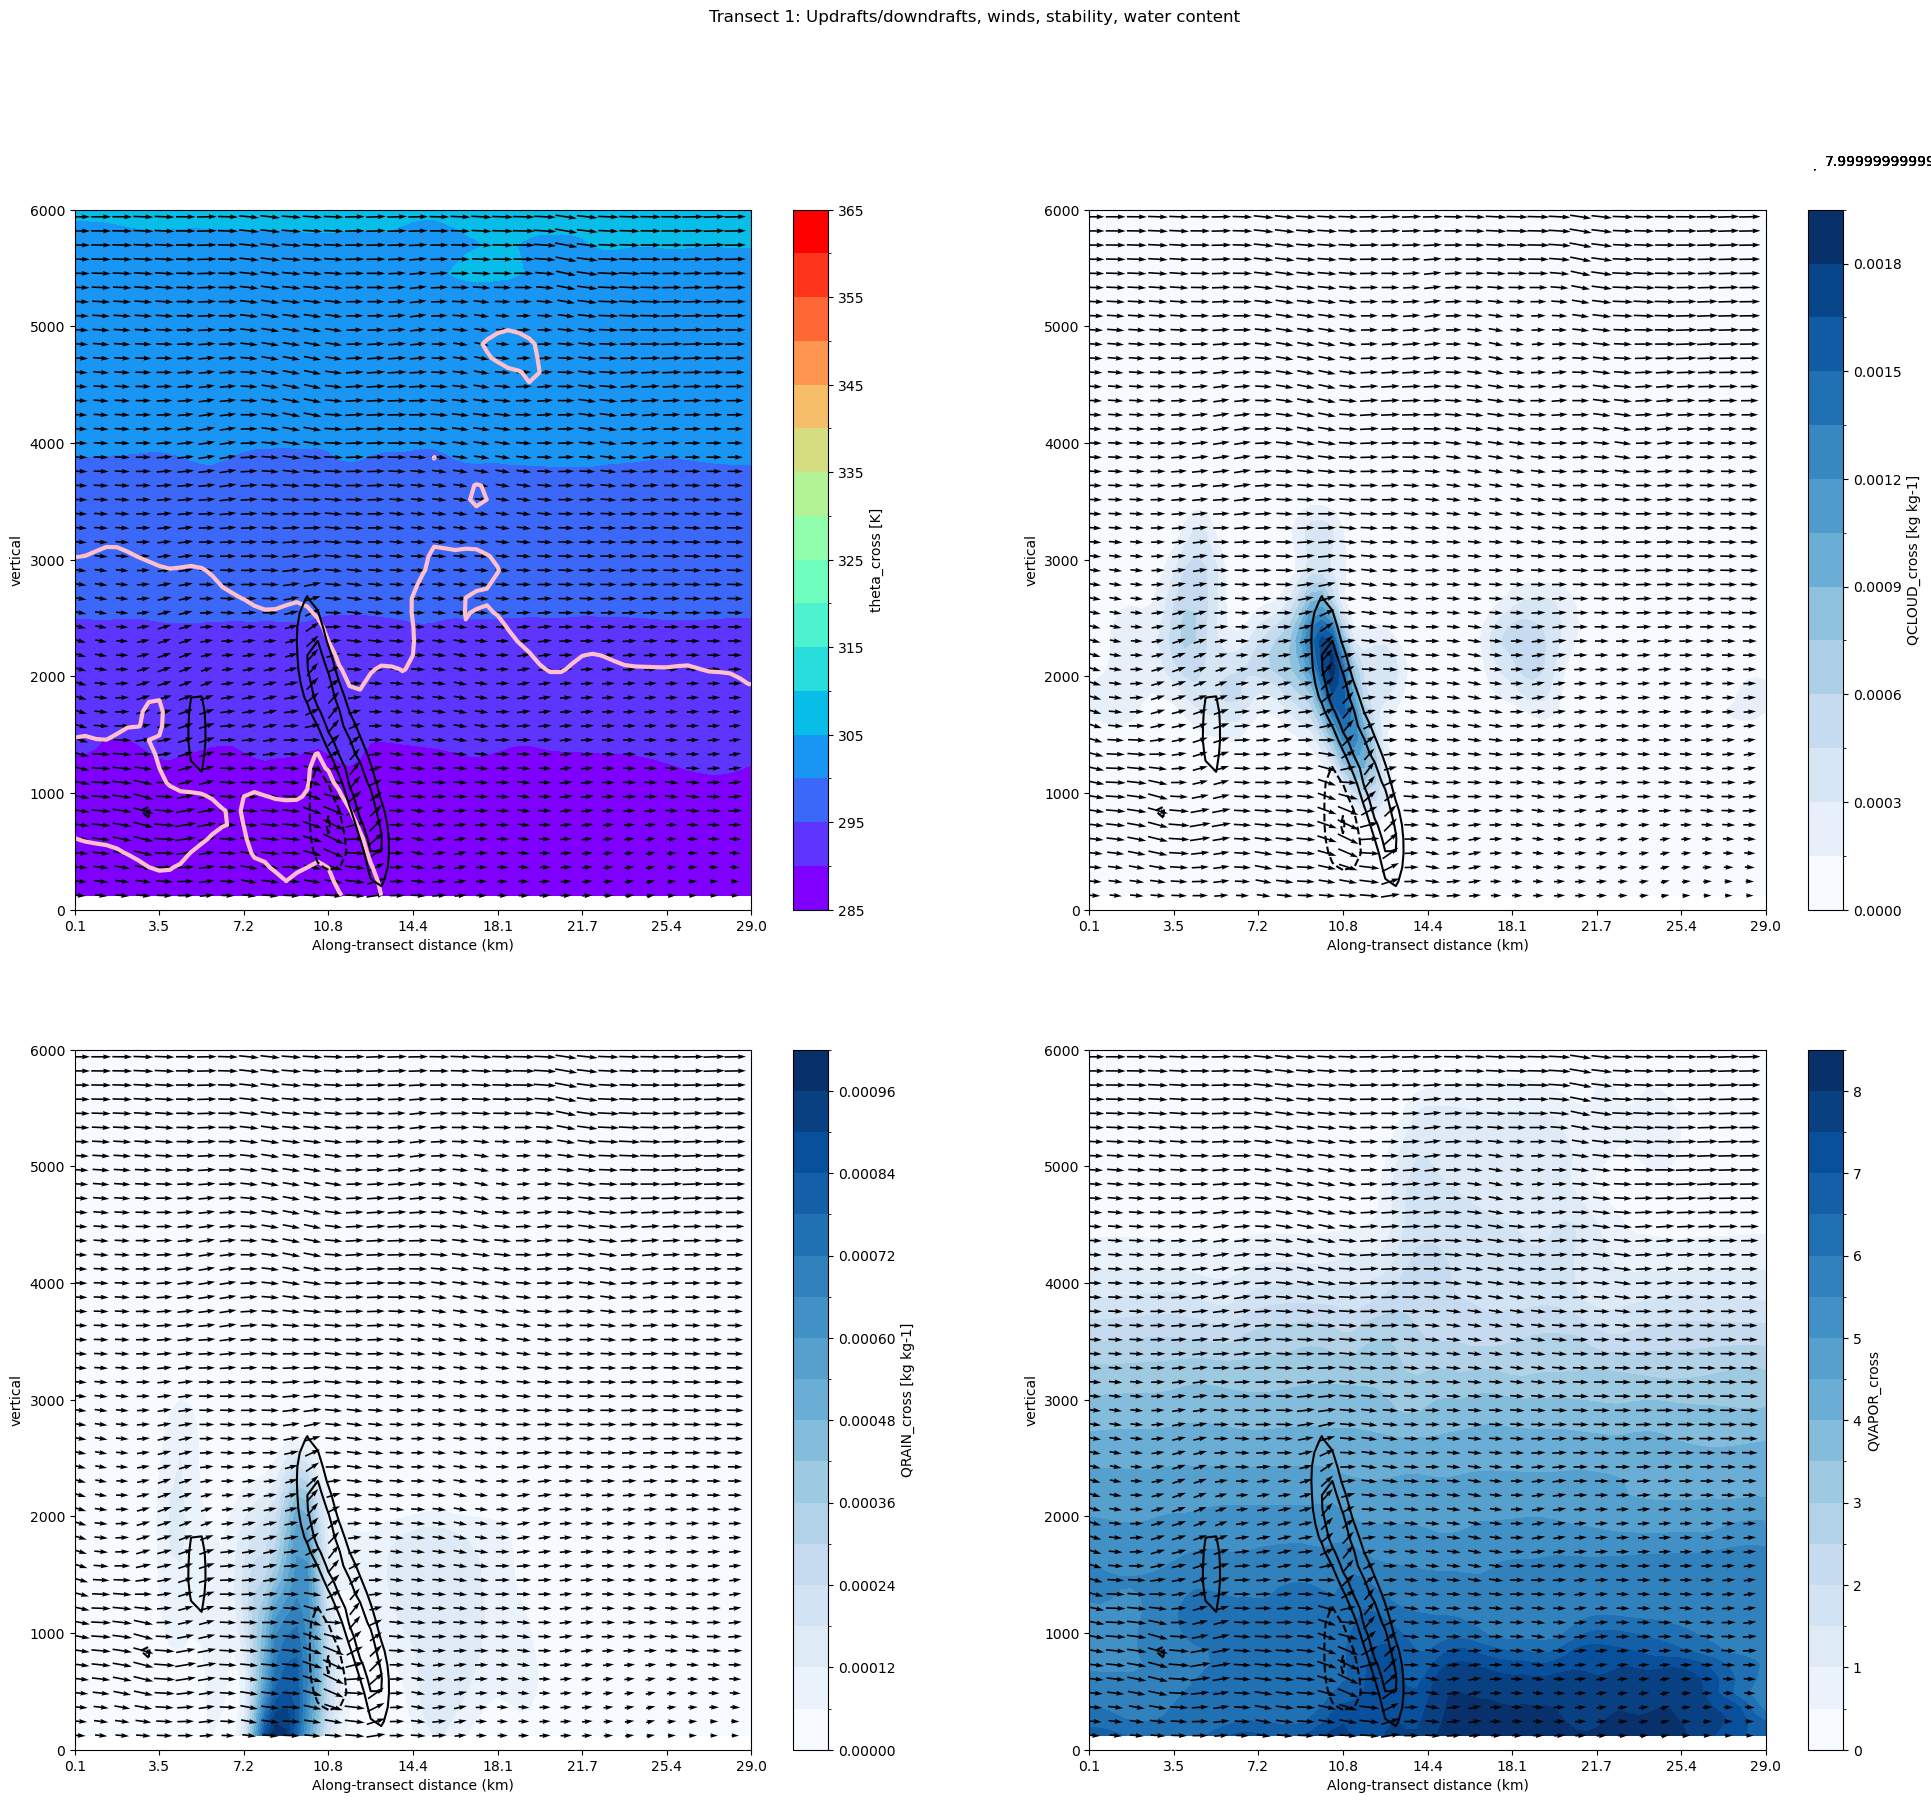

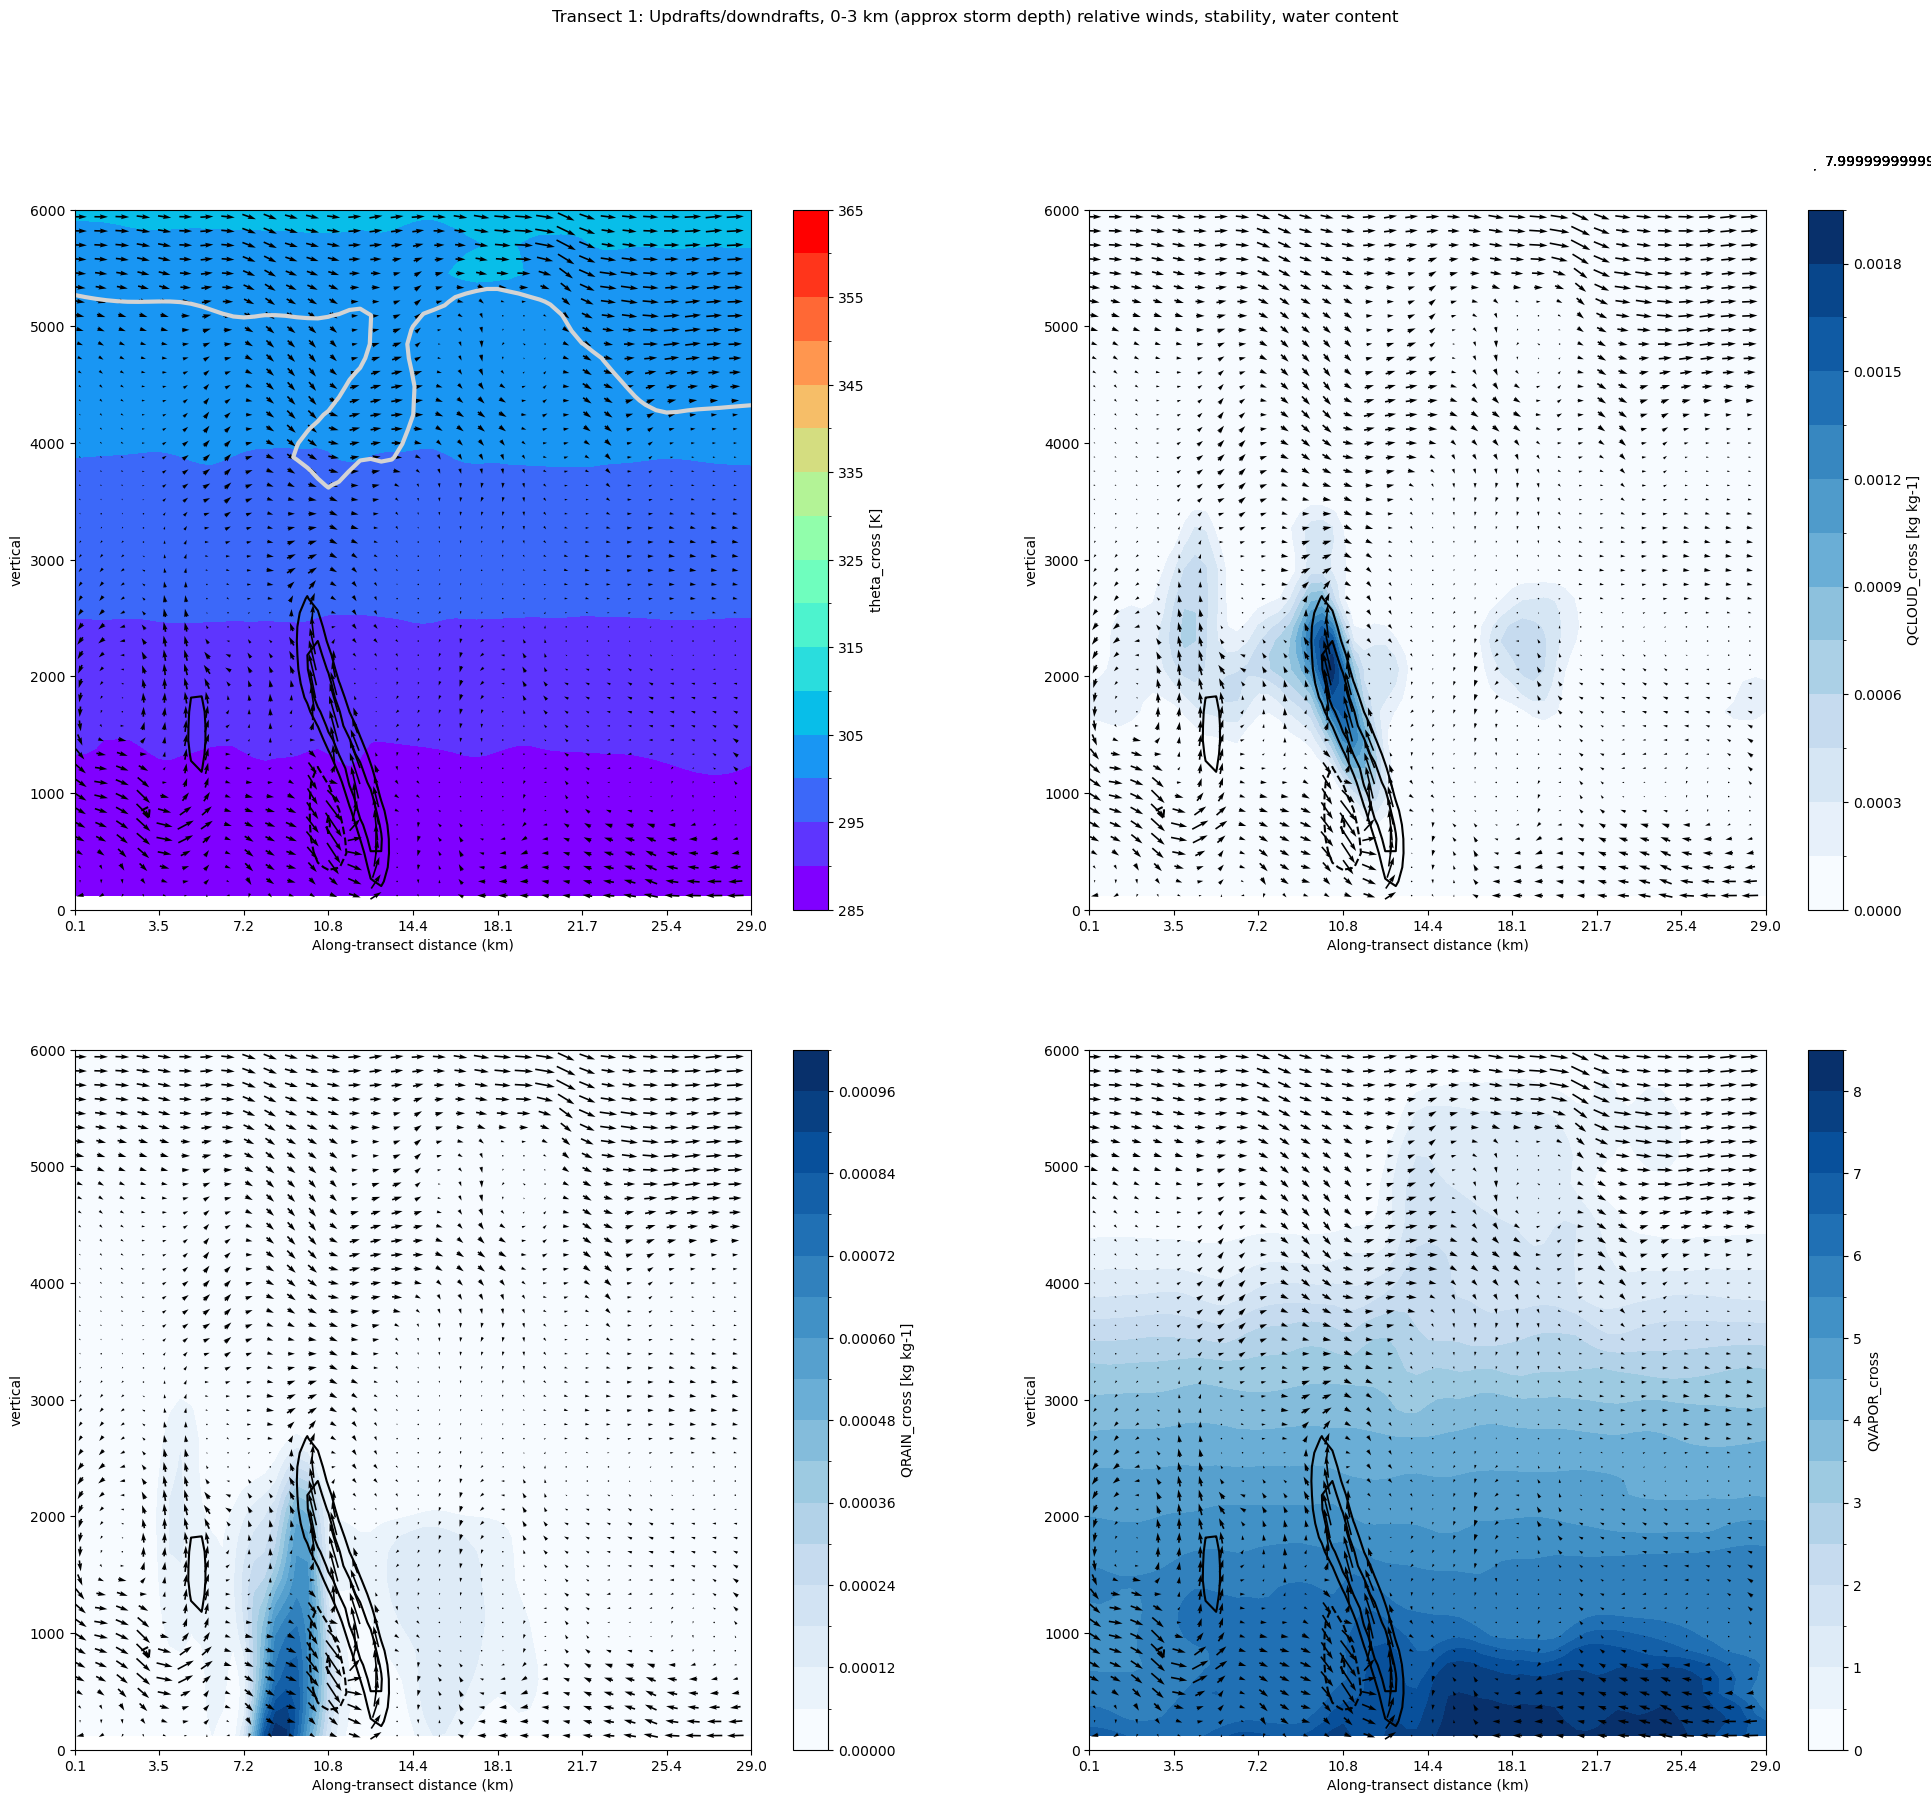

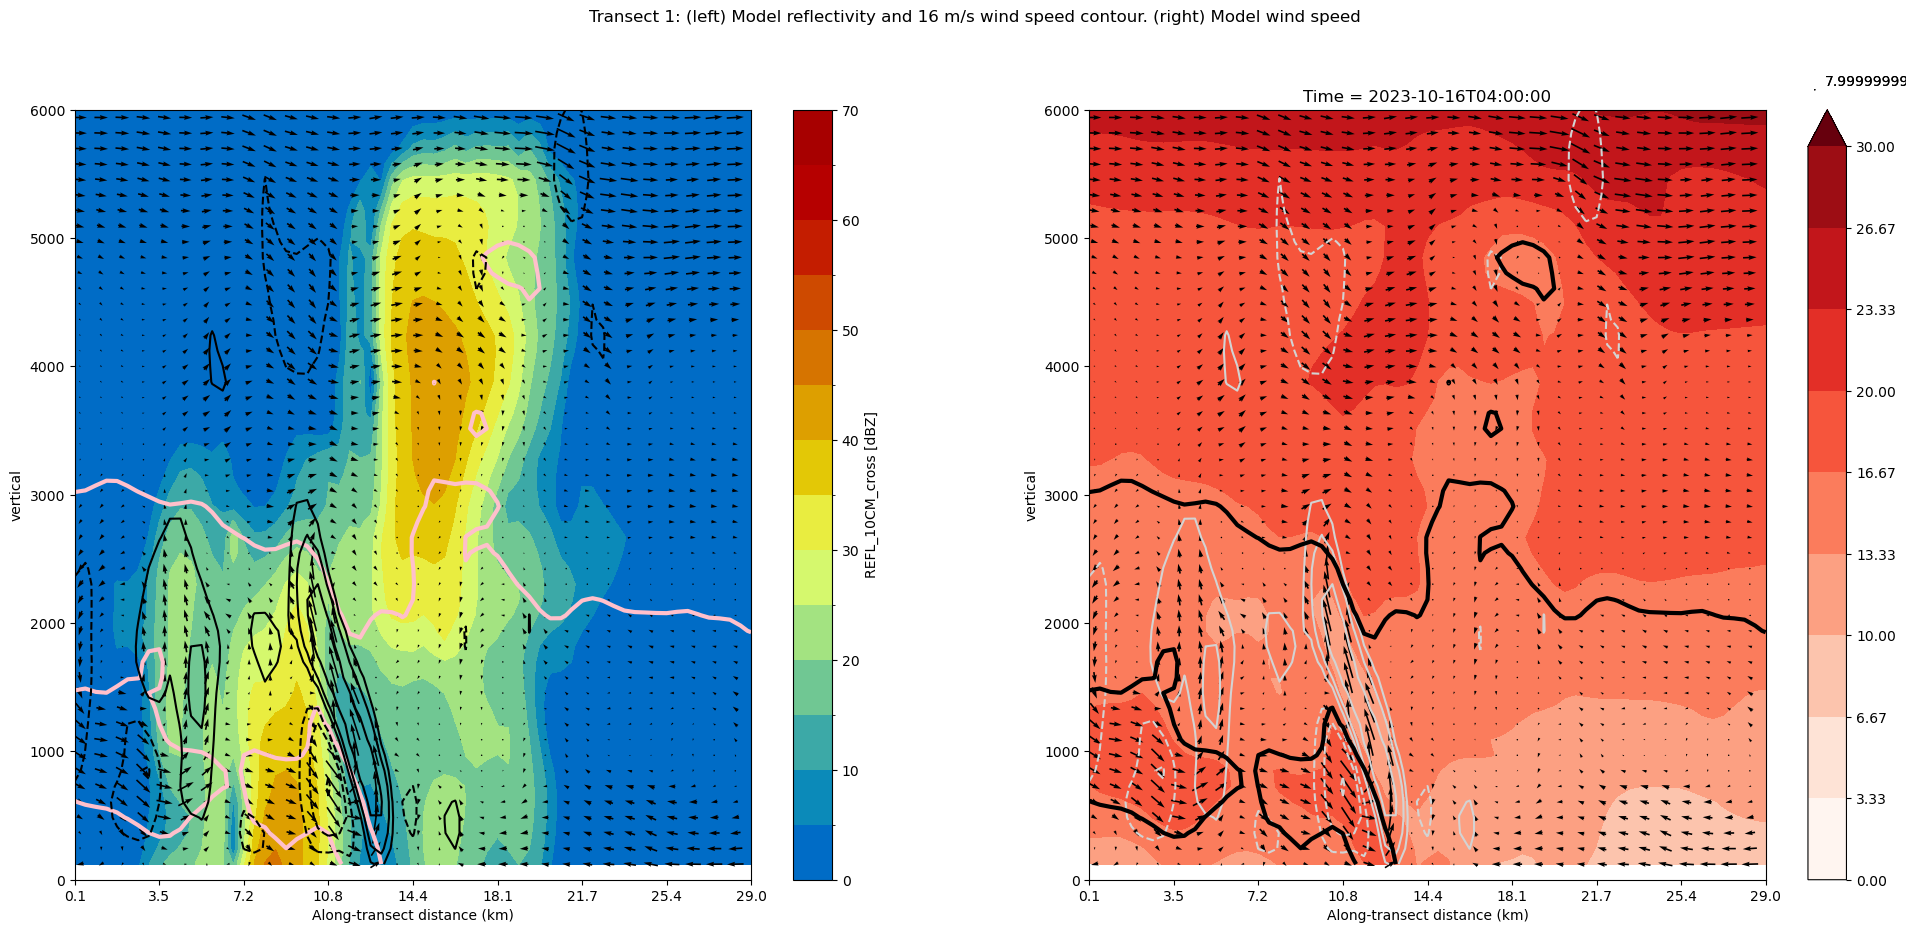

In [192]:
lats = lats1
lons = lons1
    
start_point = wrf.CoordPair(lat=lats[0],lon=lons[0])
end_point = wrf.CoordPair(lat=lats[1],lon=lons[1])
y1=lats[0]; y2=lats[1]
x1=lons[0]; x2=lons[1]
angle = np.arctan2((x2-x1),(y2-y1))

top=12000
theta_cross = wrf.vertcross(theta,heights,wrfin=wrflist[t_ind],levels=np.linspace(0,top,100),start_point=start_point,end_point=end_point)
p_cross = wrf.vertcross(P,heights,wrfin=wrflist[t_ind],levels=np.linspace(0,top,100),start_point=start_point,end_point=end_point)
u_cross = wrf.vertcross(U,heights,wrfin=wrflist[t_ind],levels=np.linspace(0,top,100),start_point=start_point,end_point=end_point)
v_cross = wrf.vertcross(V,heights,wrfin=wrflist[t_ind],levels=np.linspace(0,top,100),start_point=start_point,end_point=end_point)
w_cross = wrf.vertcross(W,heights,wrfin=wrflist[t_ind],levels=np.linspace(0,top,100),start_point=start_point,end_point=end_point)
qr_cross = wrf.vertcross(QR,heights,wrfin=wrflist[t_ind],levels=np.linspace(0,top,100),start_point=start_point,end_point=end_point,latlon=True)
qv_cross = wrf.vertcross(QV,heights,wrfin=wrflist[t_ind],levels=np.linspace(0,top,100),start_point=start_point,end_point=end_point,)
qc_cross = wrf.vertcross(QC,heights,wrfin=wrflist[t_ind],levels=np.linspace(0,top,100),start_point=start_point,end_point=end_point,)

uu_cross = np.cos(angle) * u_cross - np.sin(angle) * v_cross
vv_cross = np.sin(angle) * u_cross + np.cos(angle) * v_cross

REFL = wrf.getvar(wrflist,"REFL_10CM",timeidx=t_ind)
refl_cross = wrf.vertcross(REFL,heights,wrfin=wrflist[t_ind],levels=np.linspace(0,top,100),start_point=start_point,end_point=end_point,latlon=True)

plt.figure(figsize=[24,20])

plt.subplot(2,2,1)
xr.plot.contourf(theta_cross,cmap=plt.get_cmap("rainbow"),levels=20)
xr.Dataset({"uu":vv_cross,"w":w_cross*5}).assign_coords({"cross_line_idx":np.arange(uu_cross.shape[1])}).drop_vars("xy_loc")\
        .coarsen(dim={"cross_line_idx":2,"vertical":1},boundary="trim").mean()\
        .plot.quiver(x="cross_line_idx",y="vertical",u="uu",v="w",scale=600)
xr.plot.contour(np.sqrt(((uu_cross**2) + (vv_cross**2))),levels=[16],colors="pink",linewidths=3)
xr.plot.contour(w_cross,levels=[-5,-2,-1,1,2,5],colors="k")
plt.ylim([0,6000])
set_km_tick_labels(plt.gca(),qr_cross,lats,lons)

plt.subplot(2,2,2)
xr.plot.contourf(qc_cross,cmap=plt.get_cmap("Blues"),levels=20)
xr.Dataset({"uu":vv_cross,"w":w_cross*5}).assign_coords({"cross_line_idx":np.arange(uu_cross.shape[1])}).drop_vars("xy_loc")\
        .coarsen(dim={"cross_line_idx":2,"vertical":1},boundary="trim").mean()\
        .plot.quiver(x="cross_line_idx",y="vertical",u="uu",v="w",scale=600)
xr.plot.contour(w_cross,levels=[-5,-2,-1,1,2,5],colors="k")
plt.ylim([0,6000])
set_km_tick_labels(plt.gca(),qr_cross,lats,lons)

plt.subplot(2,2,3)
xr.plot.contourf(qr_cross,cmap=plt.get_cmap("Blues"),levels=20)
xr.Dataset({"uu":vv_cross,"w":w_cross*5}).assign_coords({"cross_line_idx":np.arange(uu_cross.shape[1])}).drop_vars("xy_loc")\
        .coarsen(dim={"cross_line_idx":2,"vertical":1},boundary="trim").mean()\
        .plot.quiver(x="cross_line_idx",y="vertical",u="uu",v="w",scale=600)
xr.plot.contour(w_cross,levels=[-5,-2,-1,1,2,5],colors="k")
plt.ylim([0,6000])
set_km_tick_labels(plt.gca(),qr_cross,lats,lons)

plt.subplot(2,2,4)
xr.plot.contourf(qv_cross*1000,cmap=plt.get_cmap("Blues"),levels=20)
xr.Dataset({"uu":vv_cross,"w":w_cross*5}).assign_coords({"cross_line_idx":np.arange(uu_cross.shape[1])}).drop_vars("xy_loc")\
        .coarsen(dim={"cross_line_idx":2,"vertical":1},boundary="trim").mean()\
        .plot.quiver(x="cross_line_idx",y="vertical",u="uu",v="w",scale=600)
xr.plot.contour(w_cross,levels=[-5,-2,-1,1,2,5],colors="k")
plt.ylim([0,6000])
set_km_tick_labels(plt.gca(),qr_cross,lats,lons)

plt.suptitle("Transect 1: Updrafts/downdrafts, winds, stability, water content")




#Plot the same transects, but with storm-relative (using the 0-3 km mean) winds

plt.figure(figsize=[24,20])

wind_transect = xr.Dataset({"uu":vv_cross,"w":w_cross*5}).assign_coords({"cross_line_idx":np.arange(uu_cross.shape[1])})
umean03 = wind_transect.sel({"vertical":slice(0,3000)}).uu.mean()
wind_transect["uu"] = wind_transect.uu - umean03

plt.subplot(2,2,1)
xr.plot.contourf(theta_cross,cmap=plt.get_cmap("rainbow"),levels=20)
wind_transect.drop_vars("xy_loc")\
        .coarsen(dim={"cross_line_idx":2,"vertical":1},boundary="trim").mean()\
        .plot.quiver(x="cross_line_idx",y="vertical",u="uu",v="w",scale=250)
xr.plot.contour(np.sqrt(((uu_cross**2) + (vv_cross**2))),levels=[20],colors="lightgray",linewidths=3)
xr.plot.contour(w_cross,levels=[-5,-2,-1,1,2,5],colors="k")
plt.ylim([0,6000])
set_km_tick_labels(plt.gca(),qr_cross,lats,lons)

plt.subplot(2,2,2)
xr.plot.contourf(qc_cross,cmap=plt.get_cmap("Blues"),levels=20)
wind_transect.drop_vars("xy_loc")\
        .coarsen(dim={"cross_line_idx":2,"vertical":1},boundary="trim").mean()\
        .plot.quiver(x="cross_line_idx",y="vertical",u="uu",v="w",scale=250)
xr.plot.contour(w_cross,levels=[-5,-2,-1,1,2,5],colors="k")
plt.ylim([0,6000])
set_km_tick_labels(plt.gca(),qr_cross,lats,lons)

plt.subplot(2,2,3)
xr.plot.contourf(qr_cross,cmap=plt.get_cmap("Blues"),levels=20)
wind_transect.drop_vars("xy_loc")\
        .coarsen(dim={"cross_line_idx":2,"vertical":1},boundary="trim").mean()\
        .plot.quiver(x="cross_line_idx",y="vertical",u="uu",v="w",scale=250)
xr.plot.contour(w_cross,levels=[-5,-2,-1,1,2,5],colors="k")
plt.ylim([0,6000])
set_km_tick_labels(plt.gca(),qr_cross,lats,lons)

plt.subplot(2,2,4)
xr.plot.contourf(qv_cross*1000,cmap=plt.get_cmap("Blues"),levels=20)
wind_transect.drop_vars("xy_loc")\
        .coarsen(dim={"cross_line_idx":2,"vertical":1},boundary="trim").mean()\
        .plot.quiver(x="cross_line_idx",y="vertical",u="uu",v="w",scale=250)
xr.plot.contour(w_cross,levels=[-5,-2,-1,1,2,5],colors="k")
plt.ylim([0,6000])
set_km_tick_labels(plt.gca(),qr_cross,lats,lons)

plt.suptitle("Transect 1: Updrafts/downdrafts, 0-3 km (approx storm depth) relative winds, stability, water content")



#Same plot but with model reflectivity

plt.figure(figsize=[24,10])

plt.subplot(1,2,1)

wind_transect = xr.Dataset({"uu":vv_cross,"w":w_cross*5}).assign_coords({"cross_line_idx":np.arange(uu_cross.shape[1])})
umean03 = wind_transect.sel({"vertical":slice(0,3000)}).uu.mean()
wind_transect["uu"] = wind_transect.uu - umean03

xr.plot.contourf(refl_cross,cmap=pyart.graph.cm_colorblind.HomeyerRainbow,levels=np.arange(0,75,5))
wind_transect.drop_vars("xy_loc")\
        .coarsen(dim={"cross_line_idx":2,"vertical":1},boundary="trim").mean()\
        .plot.quiver(x="cross_line_idx",y="vertical",u="uu",v="w",scale=250)
xr.plot.contour(np.sqrt(((uu_cross**2) + (vv_cross**2))),levels=[16],colors="pink",linewidths=3)
xr.plot.contour(w_cross,levels=[-2,-1,-0.5,0.5,1,2],colors="k")
plt.ylim([0,6000])
set_km_tick_labels(plt.gca(),qr_cross,lats,lons)

#Same plot but wind speed

plt.subplot(1,2,2)
wind_transect = xr.Dataset({"uu":vv_cross,"w":w_cross*5}).assign_coords({"cross_line_idx":np.arange(uu_cross.shape[1])})
umean03 = wind_transect.sel({"vertical":slice(0,3000)}).uu.mean()
wind_transect["uu"] = wind_transect.uu - umean03

xr.plot.contourf(np.sqrt(((uu_cross**2) + (vv_cross**2))),cmap=plt.get_cmap("Reds"),levels=np.linspace(0,30,10))
wind_transect.drop_vars("xy_loc")\
        .coarsen(dim={"cross_line_idx":2,"vertical":1},boundary="trim").mean()\
        .plot.quiver(x="cross_line_idx",y="vertical",u="uu",v="w",scale=250)
xr.plot.contour(w_cross,levels=[-2,-1,-0.5,0.5,1,2],colors="lightgray")
plt.ylim([0,6000])
xr.plot.contour(np.sqrt(((uu_cross**2) + (vv_cross**2))),levels=[16],colors="k",linewidths=3)
set_km_tick_labels(plt.gca(),qr_cross,lats,lons)

plt.suptitle("Transect 1: (left) Model reflectivity and 16 m/s wind speed contour. (right) Model wind speed");

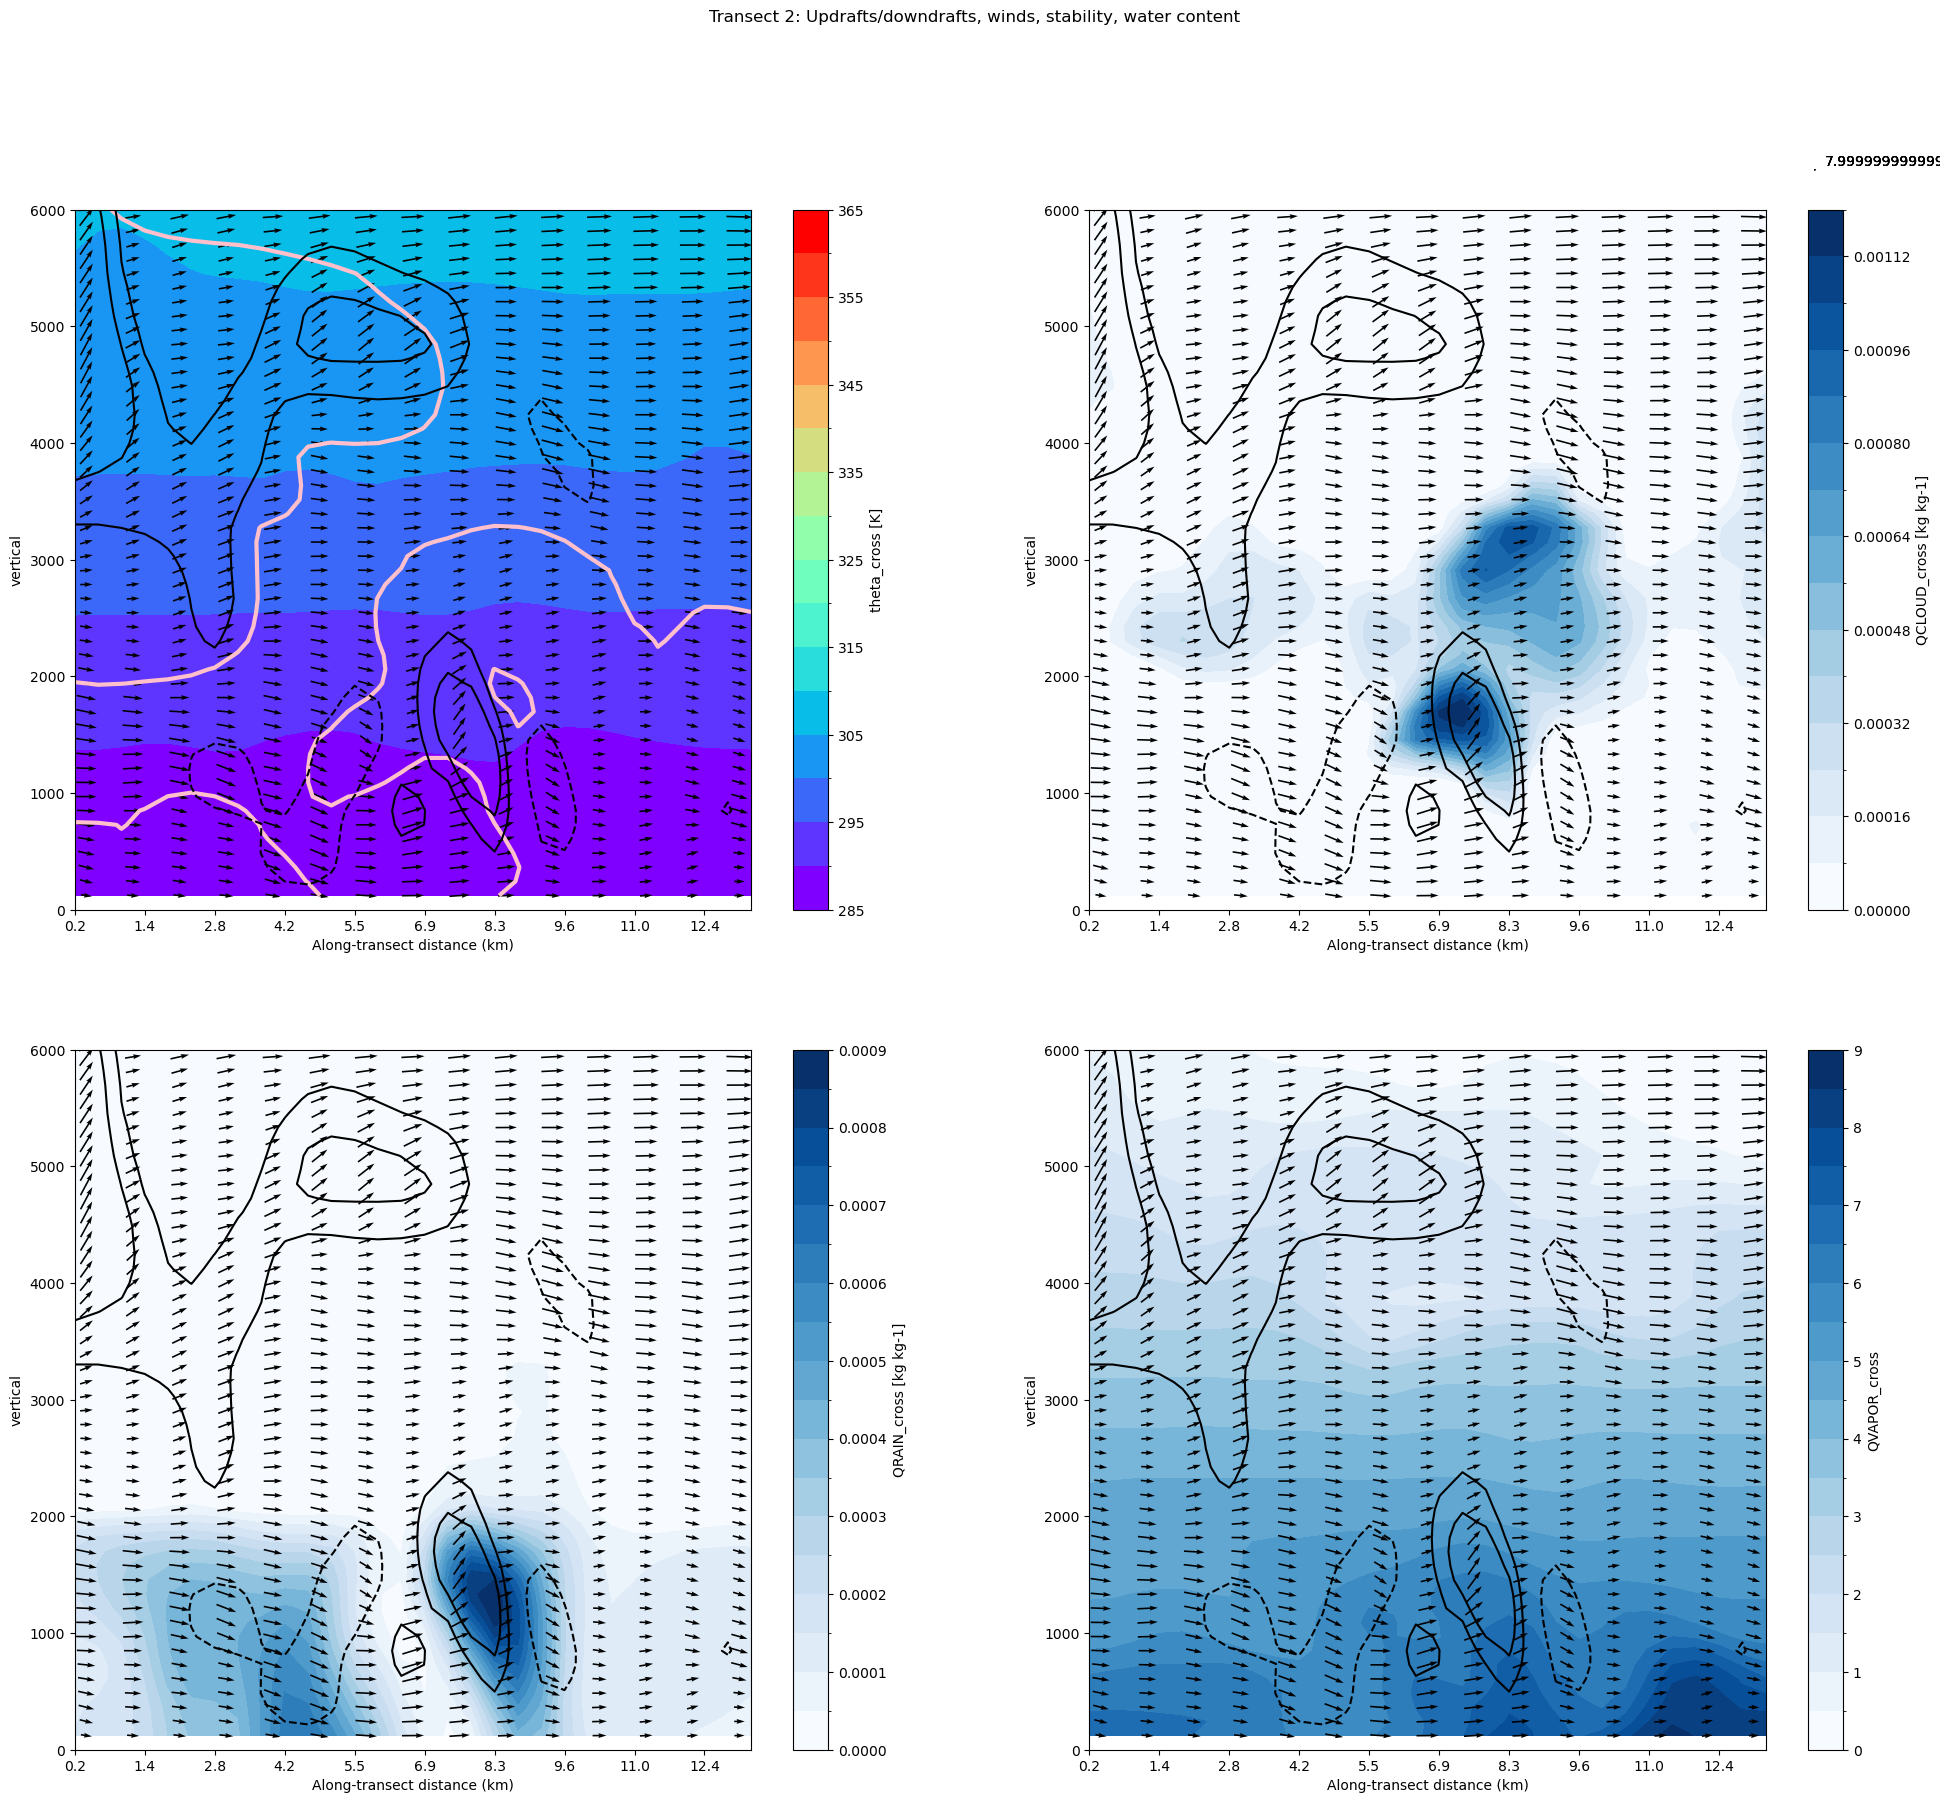

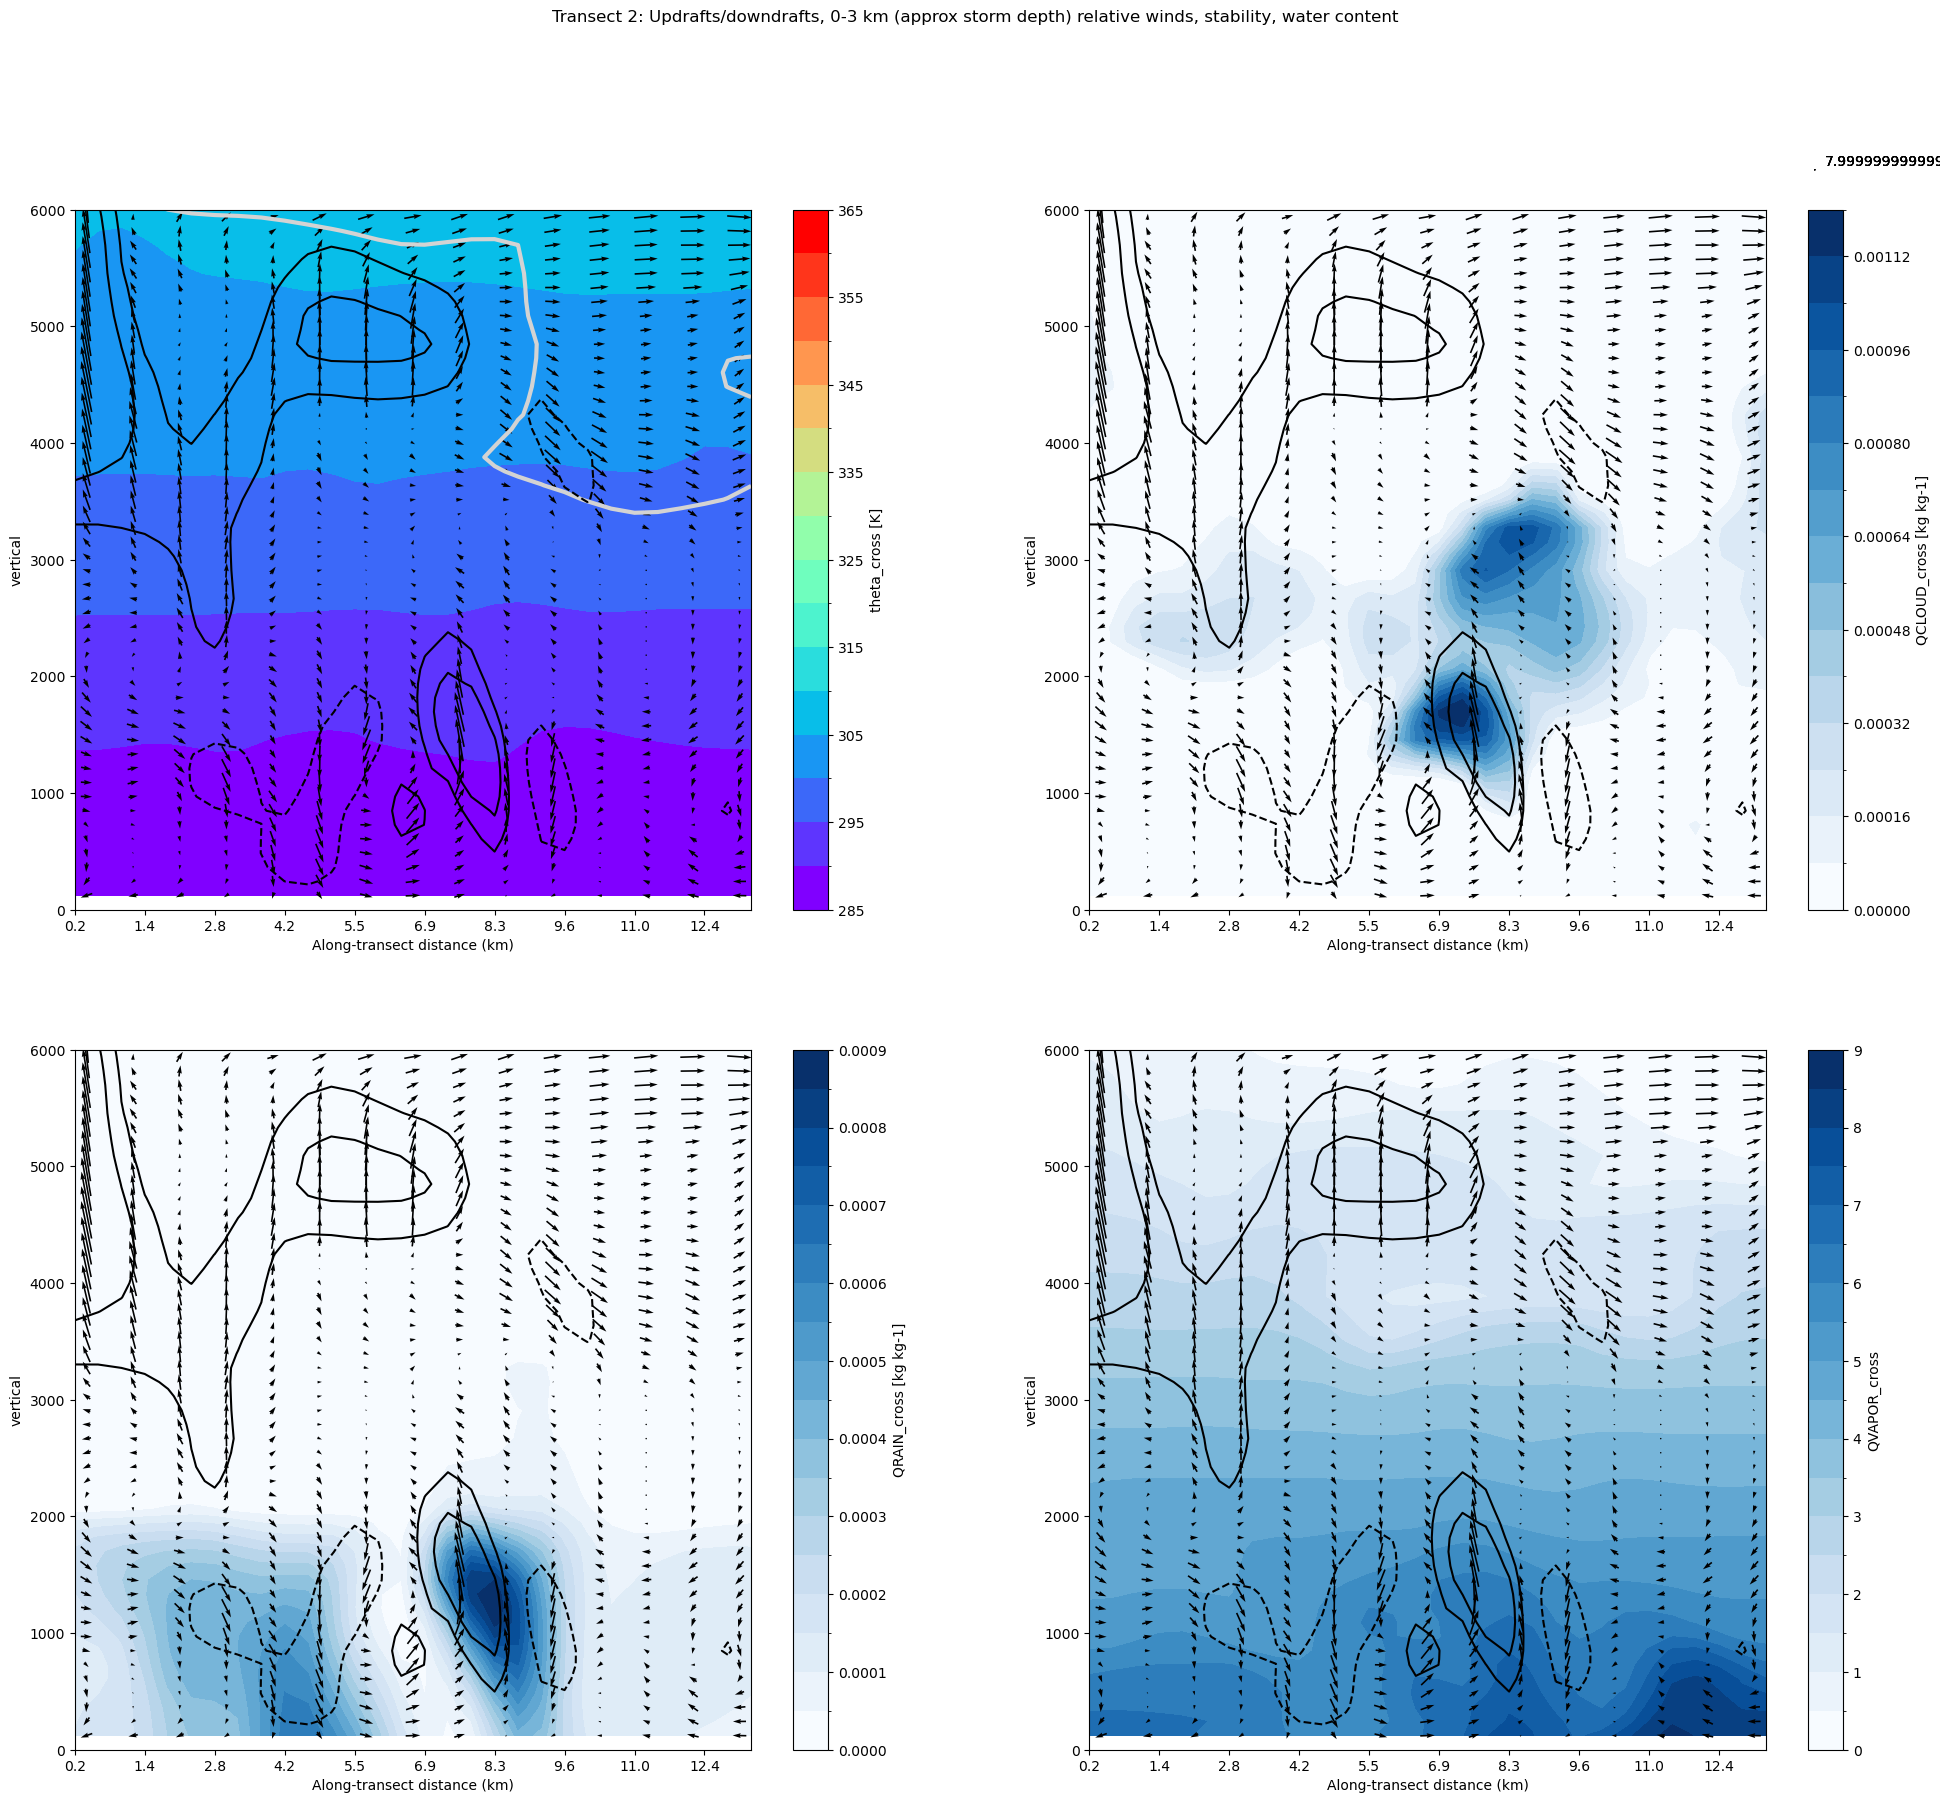

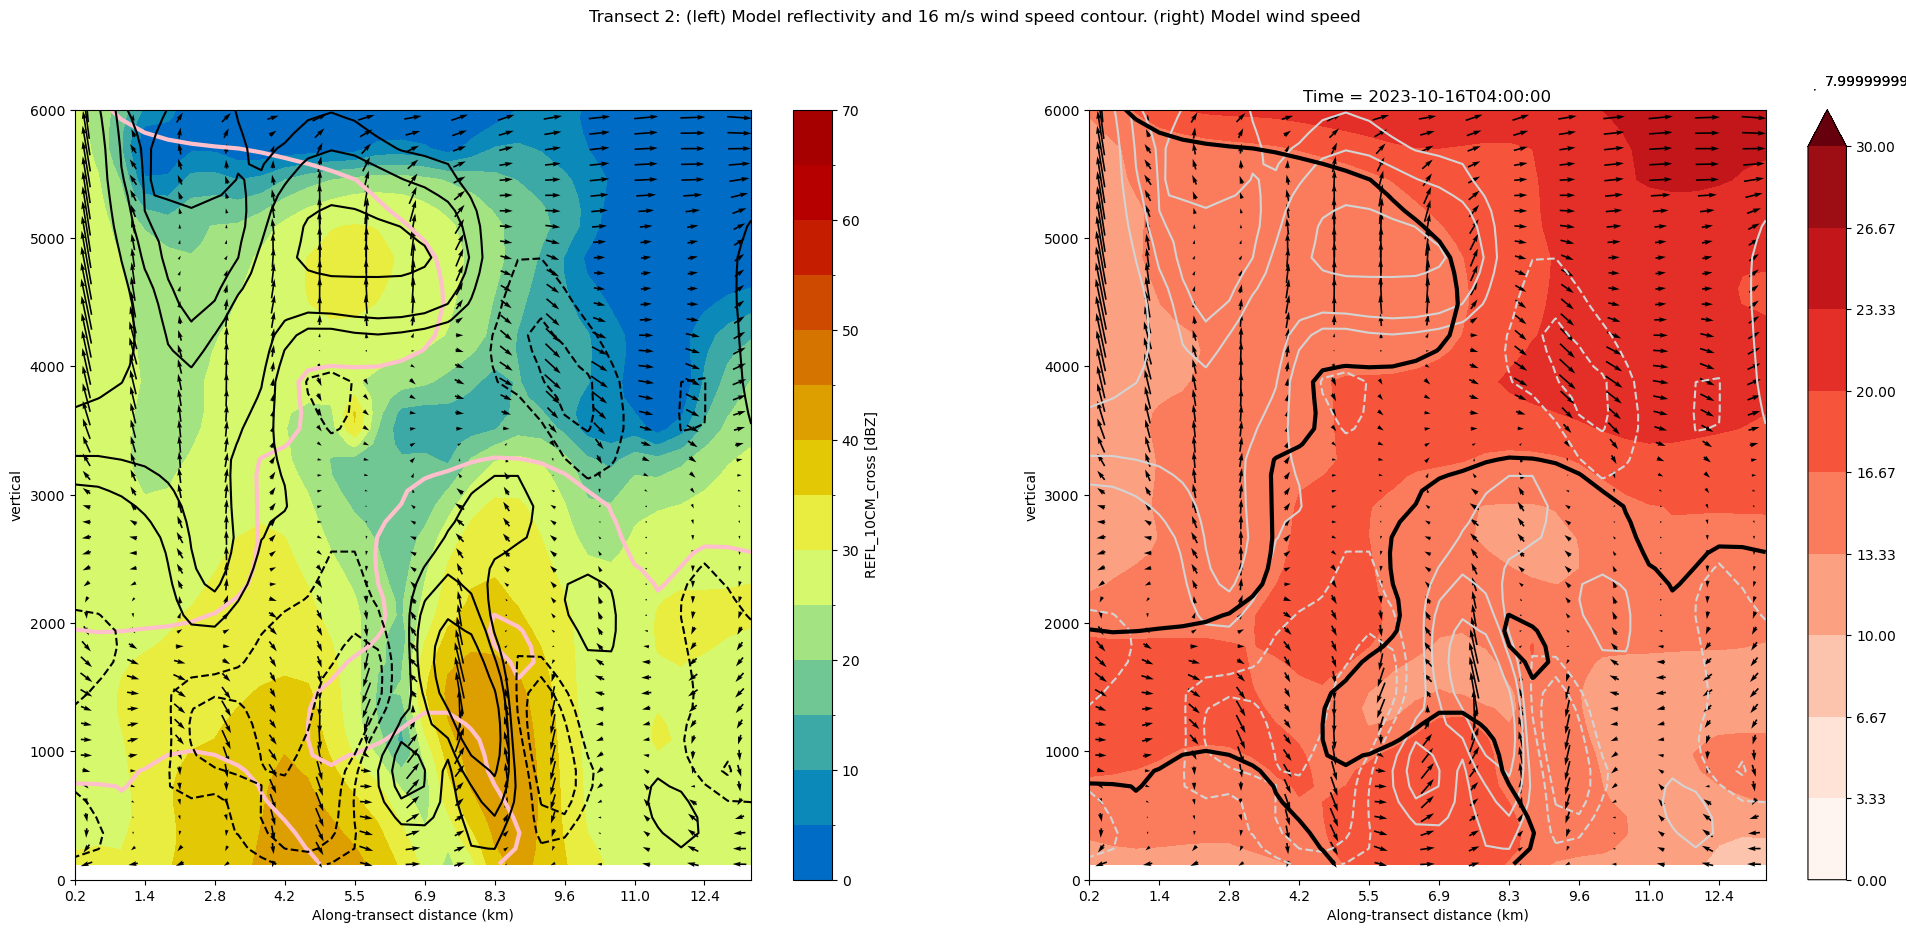

In [193]:
lats = lats2
lons = lons2

start_point = wrf.CoordPair(lat=lats[0],lon=lons[0])
end_point = wrf.CoordPair(lat=lats[1],lon=lons[1])
y1=lats[0]; y2=lats[1]
x1=lons[0]; x2=lons[1]
angle = np.arctan2((x2-x1),(y2-y1))

top=12000
theta_cross = wrf.vertcross(theta,heights,wrfin=wrflist[t_ind],levels=np.linspace(0,top,100),start_point=start_point,end_point=end_point)
p_cross = wrf.vertcross(P,heights,wrfin=wrflist[t_ind],levels=np.linspace(0,top,100),start_point=start_point,end_point=end_point)
u_cross = wrf.vertcross(U,heights,wrfin=wrflist[t_ind],levels=np.linspace(0,top,100),start_point=start_point,end_point=end_point)
v_cross = wrf.vertcross(V,heights,wrfin=wrflist[t_ind],levels=np.linspace(0,top,100),start_point=start_point,end_point=end_point)
w_cross = wrf.vertcross(W,heights,wrfin=wrflist[t_ind],levels=np.linspace(0,top,100),start_point=start_point,end_point=end_point)
qr_cross = wrf.vertcross(QR,heights,wrfin=wrflist[t_ind],levels=np.linspace(0,top,100),start_point=start_point,end_point=end_point,latlon=True)
qv_cross = wrf.vertcross(QV,heights,wrfin=wrflist[t_ind],levels=np.linspace(0,top,100),start_point=start_point,end_point=end_point,)
qc_cross = wrf.vertcross(QC,heights,wrfin=wrflist[t_ind],levels=np.linspace(0,top,100),start_point=start_point,end_point=end_point,)

uu_cross = np.cos(angle) * u_cross - np.sin(angle) * v_cross
vv_cross = np.sin(angle) * u_cross + np.cos(angle) * v_cross

REFL = wrf.getvar(wrflist,"REFL_10CM",timeidx=t_ind)
refl_cross = wrf.vertcross(REFL,heights,wrfin=wrflist[t_ind],levels=np.linspace(0,top,100),start_point=start_point,end_point=end_point,latlon=True)

plt.figure(figsize=[24,20])

plt.subplot(2,2,1)
xr.plot.contourf(theta_cross,cmap=plt.get_cmap("rainbow"),levels=20)
xr.Dataset({"uu":vv_cross,"w":w_cross*5}).assign_coords({"cross_line_idx":np.arange(uu_cross.shape[1])}).drop_vars("xy_loc")\
        .coarsen(dim={"cross_line_idx":2,"vertical":1},boundary="trim").mean()\
        .plot.quiver(x="cross_line_idx",y="vertical",u="uu",v="w",scale=600)
xr.plot.contour(np.sqrt(((uu_cross**2) + (vv_cross**2))),levels=[16],colors="pink",linewidths=3)
xr.plot.contour(w_cross,levels=[-5,-2,-1,1,2,5],colors="k")
plt.ylim([0,6000])
set_km_tick_labels(plt.gca(),qr_cross,lats,lons)

plt.subplot(2,2,2)
xr.plot.contourf(qc_cross,cmap=plt.get_cmap("Blues"),levels=20)
xr.Dataset({"uu":vv_cross,"w":w_cross*5}).assign_coords({"cross_line_idx":np.arange(uu_cross.shape[1])}).drop_vars("xy_loc")\
        .coarsen(dim={"cross_line_idx":2,"vertical":1},boundary="trim").mean()\
        .plot.quiver(x="cross_line_idx",y="vertical",u="uu",v="w",scale=600)
xr.plot.contour(w_cross,levels=[-5,-2,-1,1,2,5],colors="k")
plt.ylim([0,6000])
set_km_tick_labels(plt.gca(),qr_cross,lats,lons)

plt.subplot(2,2,3)
xr.plot.contourf(qr_cross,cmap=plt.get_cmap("Blues"),levels=20)
xr.Dataset({"uu":vv_cross,"w":w_cross*5}).assign_coords({"cross_line_idx":np.arange(uu_cross.shape[1])}).drop_vars("xy_loc")\
        .coarsen(dim={"cross_line_idx":2,"vertical":1},boundary="trim").mean()\
        .plot.quiver(x="cross_line_idx",y="vertical",u="uu",v="w",scale=600)
xr.plot.contour(w_cross,levels=[-5,-2,-1,1,2,5],colors="k")
plt.ylim([0,6000])
set_km_tick_labels(plt.gca(),qr_cross,lats,lons)

plt.subplot(2,2,4)
xr.plot.contourf(qv_cross*1000,cmap=plt.get_cmap("Blues"),levels=20)
xr.Dataset({"uu":vv_cross,"w":w_cross*5}).assign_coords({"cross_line_idx":np.arange(uu_cross.shape[1])}).drop_vars("xy_loc")\
        .coarsen(dim={"cross_line_idx":2,"vertical":1},boundary="trim").mean()\
        .plot.quiver(x="cross_line_idx",y="vertical",u="uu",v="w",scale=600)
xr.plot.contour(w_cross,levels=[-5,-2,-1,1,2,5],colors="k")
plt.ylim([0,6000])
set_km_tick_labels(plt.gca(),qr_cross,lats,lons)

plt.suptitle("Transect 2: Updrafts/downdrafts, winds, stability, water content")




#Plot the same transects, but with storm-relative (using the 0-3 km mean) winds

plt.figure(figsize=[24,20])

wind_transect = xr.Dataset({"uu":vv_cross,"w":w_cross*5}).assign_coords({"cross_line_idx":np.arange(uu_cross.shape[1])})
umean03 = wind_transect.sel({"vertical":slice(0,3000)}).uu.mean()
wind_transect["uu"] = wind_transect.uu - umean03

plt.subplot(2,2,1)
xr.plot.contourf(theta_cross,cmap=plt.get_cmap("rainbow"),levels=20)
wind_transect.drop_vars("xy_loc")\
        .coarsen(dim={"cross_line_idx":2,"vertical":1},boundary="trim").mean()\
        .plot.quiver(x="cross_line_idx",y="vertical",u="uu",v="w",scale=250)
xr.plot.contour(np.sqrt(((uu_cross**2) + (vv_cross**2))),levels=[20],colors="lightgray",linewidths=3)
xr.plot.contour(w_cross,levels=[-5,-2,-1,1,2,5],colors="k")
plt.ylim([0,6000])
set_km_tick_labels(plt.gca(),qr_cross,lats,lons)

plt.subplot(2,2,2)
xr.plot.contourf(qc_cross,cmap=plt.get_cmap("Blues"),levels=20)
wind_transect.drop_vars("xy_loc")\
        .coarsen(dim={"cross_line_idx":2,"vertical":1},boundary="trim").mean()\
        .plot.quiver(x="cross_line_idx",y="vertical",u="uu",v="w",scale=250)
xr.plot.contour(w_cross,levels=[-5,-2,-1,1,2,5],colors="k")
plt.ylim([0,6000])
set_km_tick_labels(plt.gca(),qr_cross,lats,lons)

plt.subplot(2,2,3)
xr.plot.contourf(qr_cross,cmap=plt.get_cmap("Blues"),levels=20)
wind_transect.drop_vars("xy_loc")\
        .coarsen(dim={"cross_line_idx":2,"vertical":1},boundary="trim").mean()\
        .plot.quiver(x="cross_line_idx",y="vertical",u="uu",v="w",scale=250)
xr.plot.contour(w_cross,levels=[-5,-2,-1,1,2,5],colors="k")
plt.ylim([0,6000])
set_km_tick_labels(plt.gca(),qr_cross,lats,lons)

plt.subplot(2,2,4)
xr.plot.contourf(qv_cross*1000,cmap=plt.get_cmap("Blues"),levels=20)
wind_transect.drop_vars("xy_loc")\
        .coarsen(dim={"cross_line_idx":2,"vertical":1},boundary="trim").mean()\
        .plot.quiver(x="cross_line_idx",y="vertical",u="uu",v="w",scale=250)
xr.plot.contour(w_cross,levels=[-5,-2,-1,1,2,5],colors="k")
plt.ylim([0,6000])
set_km_tick_labels(plt.gca(),qr_cross,lats,lons)

plt.suptitle("Transect 2: Updrafts/downdrafts, 0-3 km (approx storm depth) relative winds, stability, water content")



#Same plot but with model reflectivity

plt.figure(figsize=[24,10])

plt.subplot(1,2,1)

wind_transect = xr.Dataset({"uu":vv_cross,"w":w_cross*5}).assign_coords({"cross_line_idx":np.arange(uu_cross.shape[1])})
umean03 = wind_transect.sel({"vertical":slice(0,3000)}).uu.mean()
wind_transect["uu"] = wind_transect.uu - umean03

xr.plot.contourf(refl_cross,cmap=pyart.graph.cm_colorblind.HomeyerRainbow,levels=np.arange(0,75,5))
wind_transect.drop_vars("xy_loc")\
        .coarsen(dim={"cross_line_idx":2,"vertical":1},boundary="trim").mean()\
        .plot.quiver(x="cross_line_idx",y="vertical",u="uu",v="w",scale=250)
xr.plot.contour(np.sqrt(((uu_cross**2) + (vv_cross**2))),levels=[16],colors="pink",linewidths=3)
xr.plot.contour(w_cross,levels=[-2,-1,-0.5,0.5,1,2],colors="k")
plt.ylim([0,6000])
set_km_tick_labels(plt.gca(),qr_cross,lats,lons)

#Same plot but wind speed

plt.subplot(1,2,2)
wind_transect = xr.Dataset({"uu":vv_cross,"w":w_cross*5}).assign_coords({"cross_line_idx":np.arange(uu_cross.shape[1])})
umean03 = wind_transect.sel({"vertical":slice(0,3000)}).uu.mean()
wind_transect["uu"] = wind_transect.uu - umean03

xr.plot.contourf(np.sqrt(((uu_cross**2) + (vv_cross**2))),cmap=plt.get_cmap("Reds"),levels=np.linspace(0,30,10))
wind_transect.drop_vars("xy_loc")\
        .coarsen(dim={"cross_line_idx":2,"vertical":1},boundary="trim").mean()\
        .plot.quiver(x="cross_line_idx",y="vertical",u="uu",v="w",scale=250)
xr.plot.contour(w_cross,levels=[-2,-1,-0.5,0.5,1,2],colors="lightgray")
plt.ylim([0,6000])
xr.plot.contour(np.sqrt(((uu_cross**2) + (vv_cross**2))),levels=[16],colors="k",linewidths=3)
set_km_tick_labels(plt.gca(),qr_cross,lats,lons)

plt.suptitle("Transect 2: (left) Model reflectivity and 16 m/s wind speed contour. (right) Model wind speed");